In [1]:
import json
import random
import boto3
from botocore.exceptions import ClientError

# === S3 Bucket and Key Configuration ===
BUCKET_NAME = "sagemaker-studio-781388202187-bjh9kcrt4r4"  # Your S3 bucket name
# Original JSON file location (with COCO annotations)
JSON_KEY = "lemon-dataset/annotations/instances_default.json"
# Original images are stored under this prefix in the bucket
ORIGINAL_IMAGE_PREFIX = "lemon-dataset/images/"


In [2]:
# Define the output folder structure in S3
SUBSET_ROOT = "image_subset/"

# "allsubset" will contain all filtered images and annotations.
ALLSUBSET_PREFIX = SUBSET_ROOT + "allsubset/"
ALLSUBSET_IMAGES_PREFIX = ALLSUBSET_PREFIX + "images/"

# Each split folder will contain its own images subfolder and annotations.
TRAIN_PREFIX = SUBSET_ROOT + "train/"
TRAIN_IMAGES_PREFIX = TRAIN_PREFIX + "images/"
VAL_PREFIX   = SUBSET_ROOT + "val/"
VAL_IMAGES_PREFIX = VAL_PREFIX + "images/"
TEST_PREFIX  = SUBSET_ROOT + "test/"
TEST_IMAGES_PREFIX = TEST_PREFIX + "images/"

In [3]:
# Initialize the S3 client.
s3 = boto3.client('s3')

# === Helper Functions ===
def download_json_from_s3(bucket, key, local_path="annotations.json"):
    """Download the JSON annotation file from S3."""
    s3.download_file(bucket, key, local_path)
    return local_path

def delete_all_objects_with_prefix(bucket, prefix):
    """Delete all objects in the specified S3 bucket that start with the given prefix."""
    paginator = s3.get_paginator('list_objects_v2')
    for page in paginator.paginate(Bucket=bucket, Prefix=prefix):
        if "Contents" in page:
            objects_to_delete = [{"Key": obj["Key"]} for obj in page["Contents"]]
            s3.delete_objects(Bucket=bucket, Delete={"Objects": objects_to_delete})
            print(f"Deleted {len(objects_to_delete)} objects under {prefix}")

def copy_s3_object(bucket, source_key, dest_key):
    """Copy an object within the same bucket."""
    try:
        copy_source = {"Bucket": bucket, "Key": source_key}
        s3.copy_object(Bucket=bucket, CopySource=copy_source, Key=dest_key)
        print(f"Copied {source_key} to {dest_key}")
    except ClientError as e:
        print(f"Error copying {source_key} to {dest_key}: {e}")

def get_source_key(file_name):
    """
    Compute the source key for an image in the original images folder.
    Since we already removed the "images/" prefix from file_name,
    simply prepend the ORIGINAL_IMAGE_PREFIX.
    """
    return ORIGINAL_IMAGE_PREFIX + file_name


In [4]:
# === STEP 0: Clear Existing Data Under SUBSET_ROOT in S3 ===
print("Clearing existing objects under the subset root in S3...")
delete_all_objects_with_prefix(BUCKET_NAME, SUBSET_ROOT)

# === STEP 1: Download and Update the Original Annotations JSON ===
local_annotations_file = download_json_from_s3(BUCKET_NAME, JSON_KEY, "annotations.json")
with open(local_annotations_file, 'r') as f:
    data = json.load(f)

# Strip "images/" prefix from all image file names in the annotations.
for img in data.get("images", []):
    file_name = img.get("file_name", "")
    if file_name.startswith("images/"):
        img["file_name"] = file_name[len("images/"):]

Clearing existing objects under the subset root in S3...


In [5]:

# Save the updated annotations locally (if needed later)
with open("annotations_updated.json", "w") as f:
    json.dump(data, f)
print("Stripped 'images/' prefix from all image file names in the annotations.")


Stripped 'images/' prefix from all image file names in the annotations.


In [6]:
# === STEP 2: Filter Images and Annotations ===
# Identify category IDs for "mould" and "pedicel" (case-insensitive)
mould_cat_ids = [cat["id"] for cat in data["categories"] if cat["name"].lower() == "mould"]
pedicel_cat_ids = [cat["id"] for cat in data["categories"] if cat["name"].lower() == "pedicel"]

if not mould_cat_ids:
    raise ValueError("No category named 'mould' found in annotations.")
if not pedicel_cat_ids:
    print("Warning: No category named 'pedicel' found; only 'mould' annotations will be kept.")
# Select images that contain at least one "mould" annotation.
mould_image_ids = {ann["image_id"] for ann in data["annotations"] if ann["category_id"] in mould_cat_ids}
filtered_images = [img for img in data["images"] if img["id"] in mould_image_ids]

# Filter annotations: keep only for images with mould, remove boxes with area < 150,
# and keep only those with category "mould" or "pedicel".
filtered_annotations = []
for ann in data["annotations"]:
    if ann["image_id"] not in mould_image_ids:
        continue
    if ann["area"] < 150:
        continue
    if ann["category_id"] not in (mould_cat_ids + pedicel_cat_ids):
        continue
    filtered_annotations.append(ann)

# Update the categories list accordingly.
new_categories = [cat for cat in data["categories"] if cat["id"] in (mould_cat_ids + pedicel_cat_ids)]

# Create the complete filtered dataset.
allsubset_data = {
    "images": filtered_images,
    "annotations": filtered_annotations,
    "categories": new_categories
}


In [7]:
# === STEP 3: Upload the "allsubset" Data to S3 ===
local_allsubset_json = "allsubset_annotations.json"
with open(local_allsubset_json, 'w') as f:
    json.dump(allsubset_data, f)
allsubset_annotations_key = ALLSUBSET_PREFIX + "annotations.json"
s3.upload_file(local_allsubset_json, BUCKET_NAME, allsubset_annotations_key)
print(f"Uploaded allsubset annotations to s3://{BUCKET_NAME}/{allsubset_annotations_key}")

# Copy all filtered images to the allsubset/images/ folder.
print("Copying all filtered images to allsubset/images/ in S3...")
for img in filtered_images:
    source_key = get_source_key(img["file_name"])
    dest_key = ALLSUBSET_IMAGES_PREFIX + img["file_name"]
    copy_s3_object(BUCKET_NAME, source_key, dest_key)


Uploaded allsubset annotations to s3://sagemaker-studio-781388202187-bjh9kcrt4r4/image_subset/allsubset/annotations.json
Copying all filtered images to allsubset/images/ in S3...
Copied lemon-dataset/images/0004_B_H_0_G.jpg to image_subset/allsubset/images/0004_B_H_0_G.jpg
Copied lemon-dataset/images/0004_B_H_0_H.jpg to image_subset/allsubset/images/0004_B_H_0_H.jpg
Copied lemon-dataset/images/0004_B_H_15_G.jpg to image_subset/allsubset/images/0004_B_H_15_G.jpg
Copied lemon-dataset/images/0004_B_H_15_H.jpg to image_subset/allsubset/images/0004_B_H_15_H.jpg
Copied lemon-dataset/images/0004_B_H_30_G.jpg to image_subset/allsubset/images/0004_B_H_30_G.jpg
Copied lemon-dataset/images/0004_B_H_45_G.jpg to image_subset/allsubset/images/0004_B_H_45_G.jpg
Copied lemon-dataset/images/0004_B_H_45_H.jpg to image_subset/allsubset/images/0004_B_H_45_H.jpg
Copied lemon-dataset/images/0015_B_I_15_A.jpg to image_subset/allsubset/images/0015_B_I_15_A.jpg
Copied lemon-dataset/images/0016_B_I_0_A.jpg to i

In [8]:
# === STEP 4: Split the Dataset into Train (40%), Val (30%), and Test (30%) ===
random.shuffle(filtered_images)
n = len(filtered_images)
n_train = int(0.4 * n)
n_val   = int(0.3 * n)
train_images = filtered_images[:n_train]
val_images   = filtered_images[n_train:n_train+n_val]
test_images  = filtered_images[n_train+n_val:]
print(f"Dataset split: {len(train_images)} train, {len(val_images)} val, {len(test_images)} test images.")

def create_split_annotation(split_images):
    """Create an annotation JSON for a split containing only images in that split."""
    split_ids = {img["id"] for img in split_images}
    split_annotations = [ann for ann in filtered_annotations if ann["image_id"] in split_ids]
    return {
        "images": split_images,
        "annotations": split_annotations,
        "categories": new_categories
    }

def copy_split_images(split_images, dest_images_prefix):
    """Copy images for a split into the designated images subfolder in S3."""
    for img in split_images:
        source_key = ALLSUBSET_IMAGES_PREFIX + img["file_name"]  # Use images from the allsubset folder.
        dest_key = dest_images_prefix + img["file_name"]
        copy_s3_object(BUCKET_NAME, source_key, dest_key)

# For each split, copy images and upload split-specific annotations.
for split_name, split_images, split_prefix, split_images_prefix in [
    ("train", train_images, TRAIN_PREFIX, TRAIN_IMAGES_PREFIX),
    ("val",   val_images,   VAL_PREFIX,   VAL_IMAGES_PREFIX),
    ("test",  test_images,  TEST_PREFIX,  TEST_IMAGES_PREFIX)
]:
    print(f"Processing {split_name} split...")
    # Copy images to the split's images folder.
    copy_split_images(split_images, split_images_prefix)
    
    # Create and upload the split-specific annotations JSON.
    split_data = create_split_annotation(split_images)
    local_split_json = f"{split_name}_annotations.json"
    with open(local_split_json, 'w') as f:
        json.dump(split_data, f)
    split_annotations_key = split_prefix + "annotations.json"
    s3.upload_file(local_split_json, BUCKET_NAME, split_annotations_key)
    print(f"Uploaded {split_name} annotations to s3://{BUCKET_NAME}/{split_annotations_key}")

Dataset split: 105 train, 79 val, 80 test images.
Processing train split...
Copied image_subset/allsubset/images/0020_G_I_120_[F.jpg to image_subset/train/images/0020_G_I_120_[F.jpg
Copied image_subset/allsubset/images/0023_G_H_0_F.jpg to image_subset/train/images/0023_G_H_0_F.jpg
Copied image_subset/allsubset/images/0012_G_I_60_F.jpg to image_subset/train/images/0012_G_I_60_F.jpg
Copied image_subset/allsubset/images/0016_B_I_120_A.jpg to image_subset/train/images/0016_B_I_120_A.jpg
Copied image_subset/allsubset/images/0012_G_V_120_F.jpg to image_subset/train/images/0012_G_V_120_F.jpg
Copied image_subset/allsubset/images/0013_G_H_120_F.jpg to image_subset/train/images/0013_G_H_120_F.jpg
Copied image_subset/allsubset/images/0019_G_V_120_F.jpg to image_subset/train/images/0019_G_V_120_F.jpg
Copied image_subset/allsubset/images/0019_G_I_60_F.jpg to image_subset/train/images/0019_G_I_60_F.jpg
Copied image_subset/allsubset/images/0019_G_I_30_F.jpg to image_subset/train/images/0019_G_I_30_F.

In [11]:
import json
import numpy as np
import boto3

# Configuration: update these values as needed.
BUCKET_NAME = "sagemaker-studio-781388202187-bjh9kcrt4r4"
TRAIN_ANNOTATIONS_KEY = "image_subset/train/annotations.json"

# Initialize the S3 client.
s3 = boto3.client('s3')

# Download the train annotations JSON from S3.
response = s3.get_object(Bucket=BUCKET_NAME, Key=TRAIN_ANNOTATIONS_KEY)
annotations_data = json.loads(response['Body'].read().decode('utf-8'))

def get_box_array(box_list):
    """
    Convert a list of bounding boxes to a numpy array with shape (N, 4).
    If the list is empty, return an empty array with shape (0, 4).
    """
    if not box_list:
        return np.zeros((0, 4), dtype=np.float32)
    return np.array(box_list, dtype=np.float32)

# Build a dictionary mapping each image ID to its list of bounding boxes.
image_id_to_boxes = {}

# Initialize each image entry with an empty list.
for image in annotations_data.get("images", []):
    image_id = image.get("id")
    image_id_to_boxes[image_id] = []

# Populate the dictionary with bounding boxes from annotations.
for ann in annotations_data.get("annotations", []):
    image_id = ann.get("image_id")
    bbox = ann.get("bbox")
    # Assuming each annotation contains a "bbox" key.
    if bbox is not None:
        image_id_to_boxes[image_id].append(bbox)

# Convert lists of boxes to numpy arrays with the expected shape.
for image_id, boxes in image_id_to_boxes.items():
    boxes_array = get_box_array(boxes)
    # Log the shape of the boxes array for each image.
    print(f"Image ID {image_id}: Boxes array shape: {boxes_array.shape}")
    # Optionally, you can check for any image that ends up with shape (0,) incorrectly.
    # For safety, you might want to assert that the array always has two dimensions.
    assert boxes_array.ndim == 2 and boxes_array.shape[1] == 4, \
        f"Image ID {image_id} has invalid box dimensions: {boxes_array.shape}"

Image ID 6029: Boxes array shape: (1, 4)
Image ID 6095: Boxes array shape: (1, 4)
Image ID 5770: Boxes array shape: (1, 4)
Image ID 1686: Boxes array shape: (1, 4)
Image ID 5775: Boxes array shape: (1, 4)
Image ID 5787: Boxes array shape: (2, 4)
Image ID 6008: Boxes array shape: (1, 4)
Image ID 6004: Boxes array shape: (1, 4)
Image ID 6002: Boxes array shape: (1, 4)
Image ID 6098: Boxes array shape: (1, 4)
Image ID 5700: Boxes array shape: (1, 4)
Image ID 5733: Boxes array shape: (3, 4)
Image ID 6030: Boxes array shape: (1, 4)
Image ID 5717: Boxes array shape: (1, 4)
Image ID 6085: Boxes array shape: (1, 4)
Image ID 5489: Boxes array shape: (1, 4)
Image ID 6009: Boxes array shape: (1, 4)
Image ID 1396: Boxes array shape: (1, 4)
Image ID 6501: Boxes array shape: (1, 4)
Image ID 6059: Boxes array shape: (1, 4)
Image ID 6080: Boxes array shape: (1, 4)
Image ID 5794: Boxes array shape: (1, 4)
Image ID 5446: Boxes array shape: (2, 4)
Image ID 6046: Boxes array shape: (1, 4)
Image ID 1399: B

In [73]:
import sagemaker
from sagemaker.pytorch import PyTorch

# Set your bucket name
BUCKET_NAME = "sagemaker-studio-781388202187-bjh9kcrt4r4"

# Get the SageMaker execution role and session
role = sagemaker.get_execution_role()
session = sagemaker.Session()

# Create a PyTorch estimator for your Mask R-CNN training script
estimator = PyTorch(
    entry_point="train_lemon_maskrcnn.py",
    source_dir="/home/sagemaker-user/src",  # Directory containing your training script and requirements.txt
    role=role,
    instance_count=1,
    instance_type="ml.g4dn.xlarge",
    framework_version="1.13",
    py_version="py39",
    hyperparameters={
        "max_iter": 10000,
        "lr": 0.001,
        "early_stop_threshold": 0.05,
        "num_epochs": 100,
        "batch_size": 2
    },
    output_path=f"s3://{BUCKET_NAME}/output"
)

# Define S3 input channels
inputs = {
    "training": f"s3://{BUCKET_NAME}/image_subset"
}

# Launch the training job
estimator.fit(inputs, logs=True)


[04/07/25 23:31:43] INFO     SageMaker Python SDK will collect telemetry to help us better  ]8;id=320295;file:///opt/conda/lib/python3.11/site-packages/sagemaker/telemetry/telemetry_logging.py\telemetry_logging.py]8;;\:]8;id=375249;file:///opt/conda/lib/python3.11/site-packages/sagemaker/telemetry/telemetry_logging.py#91\91]8;;\
                             understand our user's needs, diagnose issues, and deliver                             
                             additional features.                                                                  
                             To opt out of telemetry, please disable via TelemetryOptOut                           
                             parameter in SDK defaults config. For more information, refer                         
                             to                                                                                    
                             https://sagemaker.readthedocs.io/en/stable/overview.html#confi                        
                             guring-and-using-defaults-with-the-sagemaker-python-sdk.                              

                    INFO     image_uri is not presented, retrieving image_uri based on            ]8;id=277175;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=37797;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py#681\681]8;;\
                             instance_type, framework etc.                                                         

                    INFO     image_uri is not presented, retrieving image_uri based on            ]8;id=56379;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=697791;file:///opt/conda/lib/python3.11/site-packages/sagemaker/image_uris.py#681\681]8;;\
                             instance_type, framework etc.                                                         

                    INFO     Creating training-job with name:                                       ]8;id=498057;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=97514;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py#1042\1042]8;;\
                             pytorch-training-2025-04-07-23-31-43-294                                              

2025-04-07 23:31:45 Starting - Starting the training job...
..25-04-07 23:32:00 Starting - Preparing the instances for training.
..25-04-07 23:32:29 Downloading - Downloading input data.
.................59 Downloading - Downloading the training image.
bash: cannot set terminal process group (-1): Inappropriate ioctl for devices..
bash: no job control in this shell
/opt/conda/lib/python3.9/site-packages/paramiko/pkey.py:100: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
/opt/conda/lib/python3.9/site-packages/paramiko/transport.py:259: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,
2025-04-07 23:36:15,536 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container

In [74]:
!pip install opencv-python


In [75]:
!pip install opencv-python-headless


In [76]:
!apt-get update && apt-get install -y libgl1-mesa-glx

Reading package lists... Done
E: Could not open lock file /var/lib/apt/lists/lock - open (13: Permission denied)
E: Unable to lock directory /var/lib/apt/lists/


In [107]:
import os
import boto3
import tarfile

# S3 configuration
s3_bucket = "sagemaker-studio-781388202187-bjh9kcrt4r4"
s3_key = "output/pytorch-training-2025-04-07-23-31-43-294/output/model.tar.gz"
local_tar_path = "model.tar.gz"

# Initialize the S3 client and download the model artifact
s3 = boto3.client("s3")
print("Downloading model artifact from S3...")
s3.download_file(s3_bucket, s3_key, local_tar_path)
print(f"Downloaded artifact to {local_tar_path}")

# Define a directory to extract the model artifact
extract_dir = "model_artifact"
os.makedirs(extract_dir, exist_ok=True)

print("Extracting the model artifact...")
with tarfile.open(local_tar_path, "r:gz") as tar:
    tar.extractall(path=extract_dir)
print(f"Model artifact extracted to {extract_dir}")

# Construct the full path to the model weights file
model_path = os.path.join(extract_dir, "model.pth")
if os.path.exists(model_path):
    print("Found model file at:", model_path)
else:
    raise FileNotFoundError(f"Model file not found at {model_path}")

Downloaded artifact to model.tar.gz
Extracting the model artifact...
Model artifact extracted to model_artifact
Found model file at: model_artifact/model.pth


In [81]:
import sagemaker
from sagemaker.pytorch import PyTorchModel

def deploy_model():
    sagemaker_session = sagemaker.Session()
    role = sagemaker.get_execution_role()

    model = PyTorchModel(
        model_data="s3://sagemaker-studio-781388202187-bjh9kcrt4r4/output/pytorch-training-2025-04-04-20-28-44-761/output/model.tar.gz",
        role=role,
        framework_version='1.13',
        py_version='py39',
        entry_point='inference.py',
        source_dir="/home/sagemaker-user/src",
    )

    predictor = model.deploy(
        initial_instance_count=1,
        instance_type='ml.g4dn.xlarge'
    )

    return predictor

if __name__ == "__main__":
    predictor = deploy_model()
    print(f"Model endpoint: {predictor.endpoint_name}")

[04/08/25 01:24:14] INFO     Repacking model artifact                                                  ]8;id=951243;file:///opt/conda/lib/python3.11/site-packages/sagemaker/model.py\model.py]8;;\:]8;id=191399;file:///opt/conda/lib/python3.11/site-packages/sagemaker/model.py#819\819]8;;\
                             (s3://sagemaker-studio-781388202187-bjh9kcrt4r4/output/pytorch-training-2             
                             025-04-04-20-28-44-761/output/model.tar.gz), script artifact                          
                             (/home/sagemaker-user/src), and dependencies ([]) into single tar.gz file             
                             located at                                                                            
                             s3://sagemaker-us-east-1-781388202187/pytorch-inference-2025-04-08-01-24-             
                             14-603/model.tar.gz. This may take some time depending on model size...               

[04/08/25 01:24:26] INFO     Creating model with name: pytorch-inference-2025-04-08-01-24-26-689    ]8;id=27639;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=25900;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py#4094\4094]8;;\

[04/08/25 01:24:27] INFO     Creating endpoint-config with name                                     ]8;id=86846;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=132974;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py#5889\5889]8;;\
                             pytorch-inference-2025-04-08-01-24-27-526                                             

                    INFO     Creating endpoint with name pytorch-inference-2025-04-08-01-24-27-526  ]8;id=763982;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=737135;file:///opt/conda/lib/python3.11/site-packages/sagemaker/session.py#4711\4711]8;;\

-----------!Model endpoint: pytorch-inference-2025-04-08-01-24-27-526


In [85]:
import boto3
sm_client = boto3.client('sagemaker')
endpoints = sm_client.list_endpoints()
for endpoint in endpoints['Endpoints']:
    print(f"{endpoint['EndpointName']}: {endpoint['EndpointStatus']}")

pytorch-inference-2025-04-08-01-24-27-526: InService
pytorch-inference-2025-04-03-03-48-58-604: InService
pytorch-inference-2025-04-02-22-52-29-199: InService



Testing image: image_subset/test/images/0012_G_V_90_F.jpg


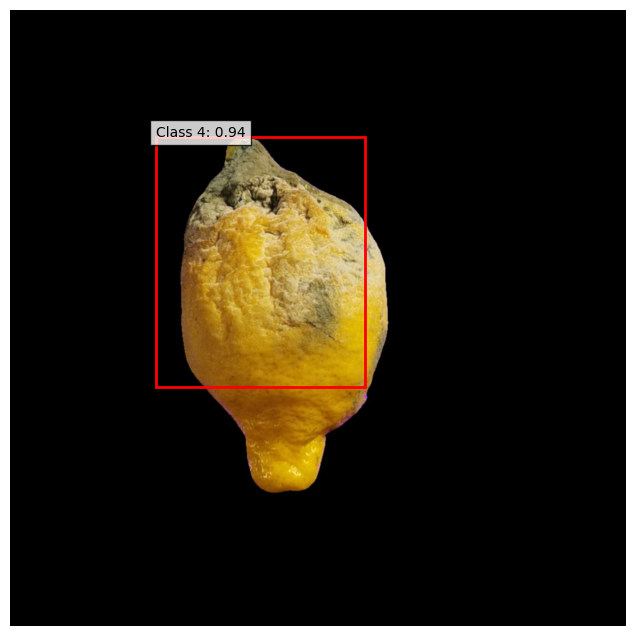


Testing image: image_subset/test/images/0022_G_V_30_F.jpg


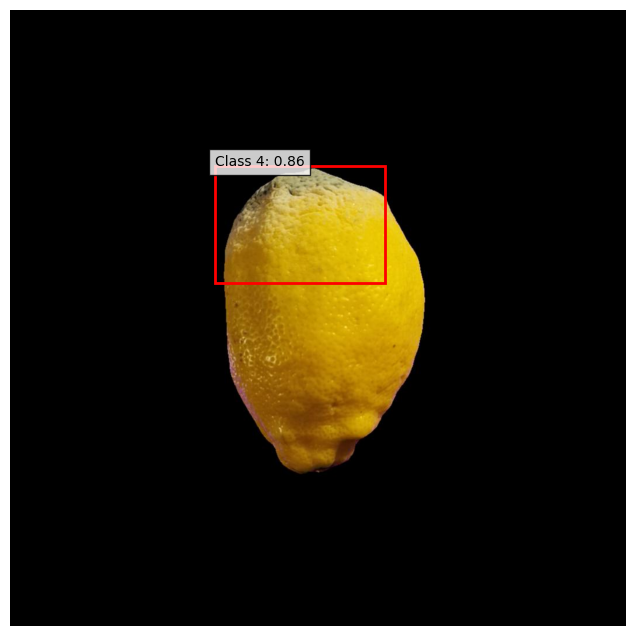


Testing image: image_subset/test/images/0022_G_V_105_F.jpg


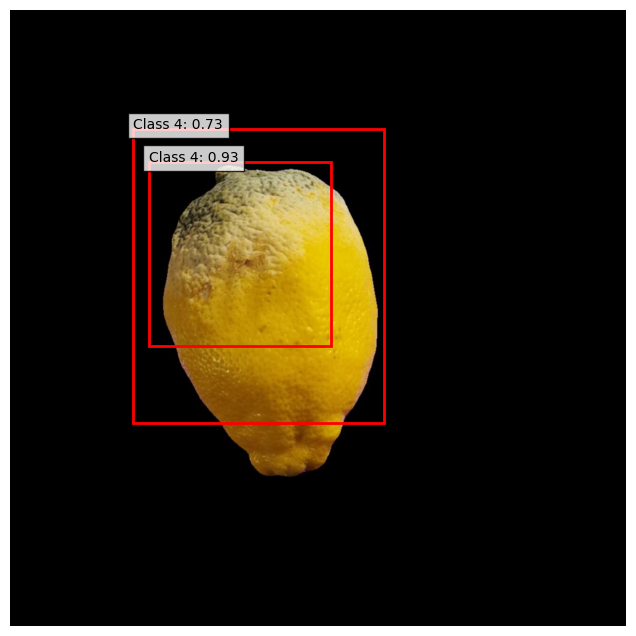


Testing image: image_subset/test/images/0021_G_I_90_F.jpg


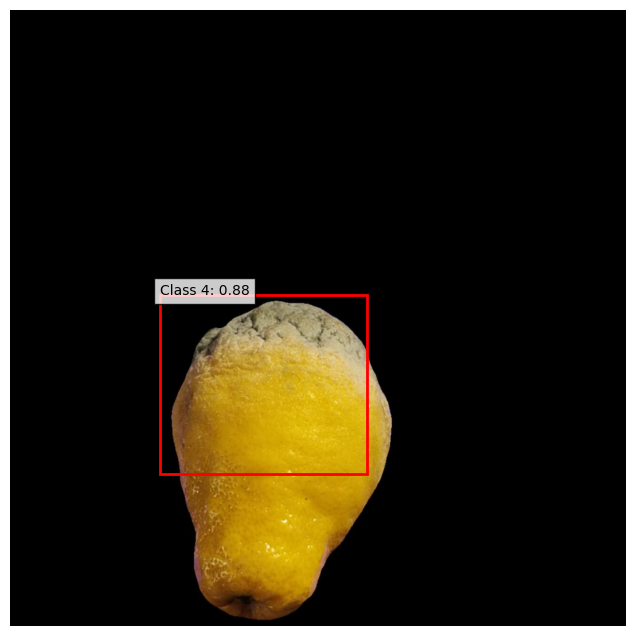


Testing image: image_subset/test/images/0020_G_I_0_[F.jpg


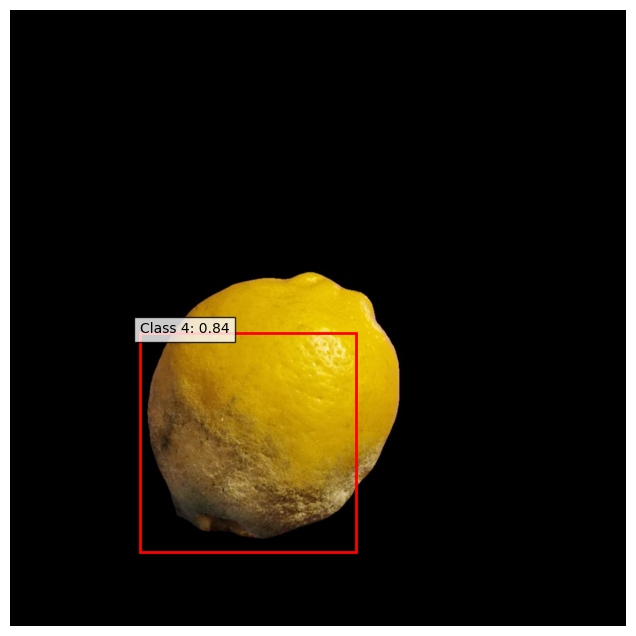


Testing image: image_subset/test/images/0013_G_H_30_F.jpg


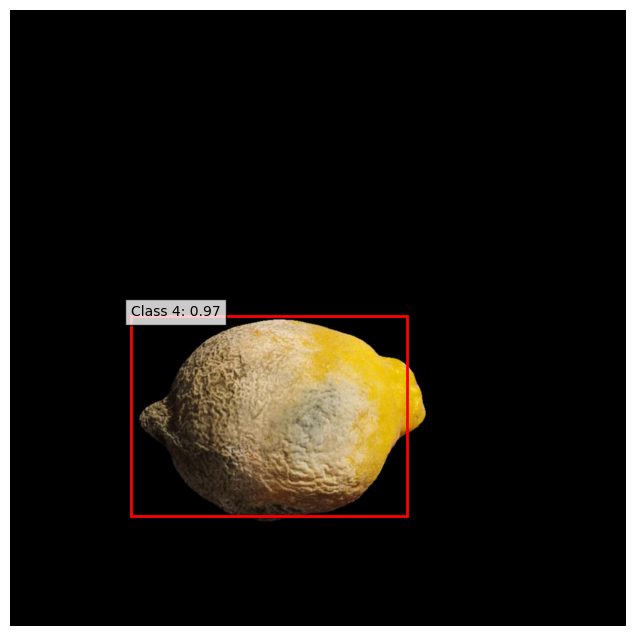


Testing image: image_subset/test/images/0002_C_V_45_H.jpg


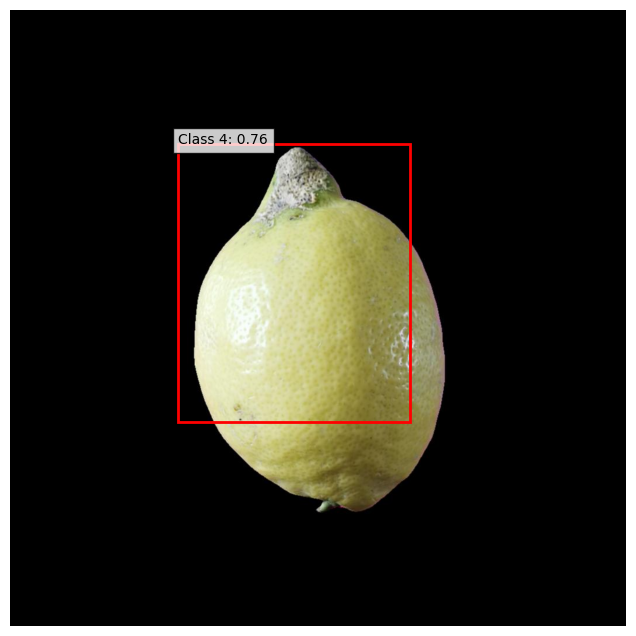


Testing image: image_subset/test/images/0002_G_I_120_A.jpg


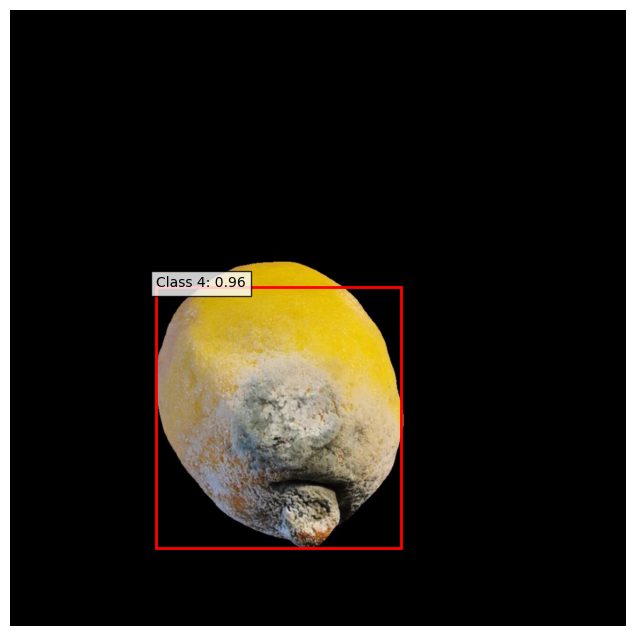


Testing image: image_subset/test/images/0002_G_I_150_A.jpg


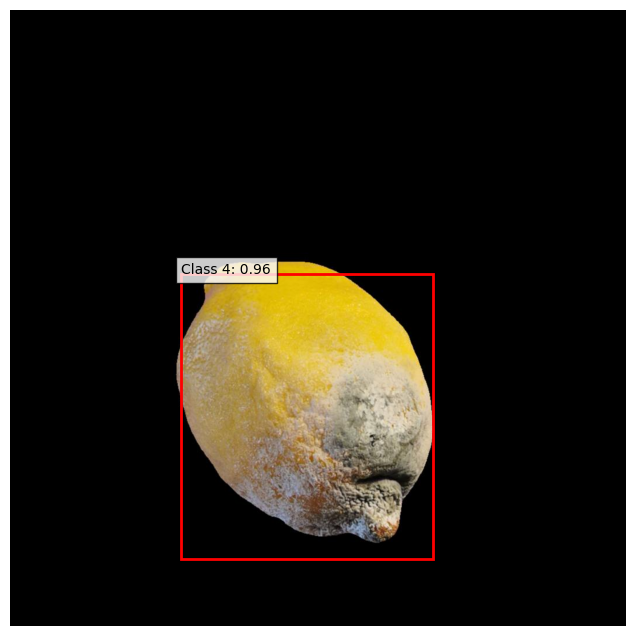


Testing image: image_subset/test/images/0020_G_V_165_F.jpg


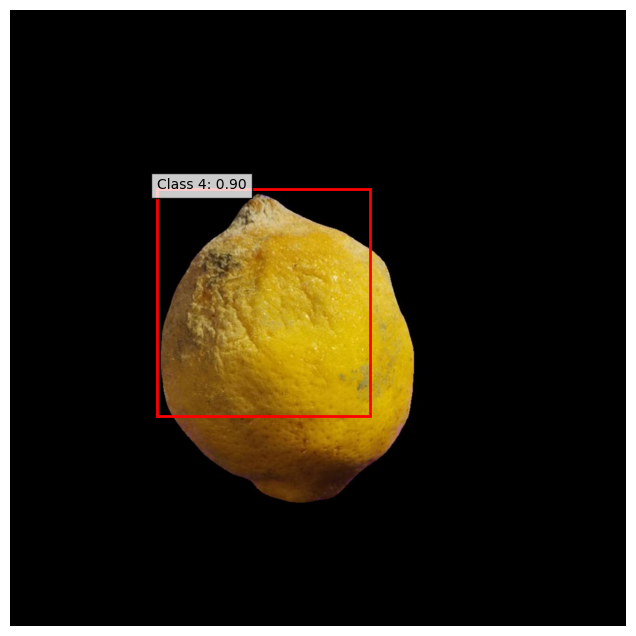


Testing image: image_subset/test/images/0022_G_H_90_F.jpg


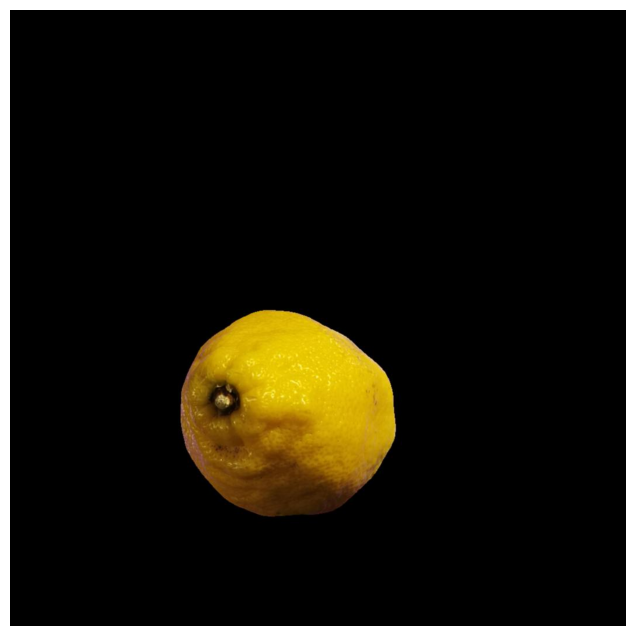


Testing image: image_subset/test/images/0010_G_I_75_A.jpg


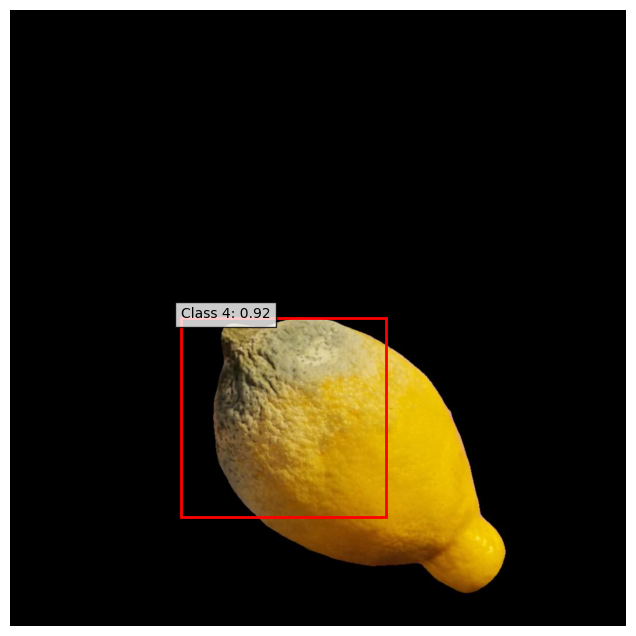


Testing image: image_subset/test/images/0002_G_H_60_A.jpg


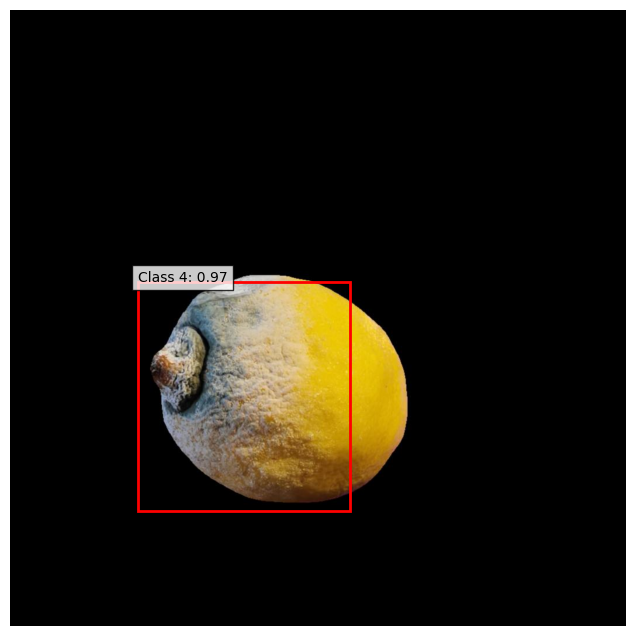


Testing image: image_subset/test/images/0012_G_V_75_F.jpg


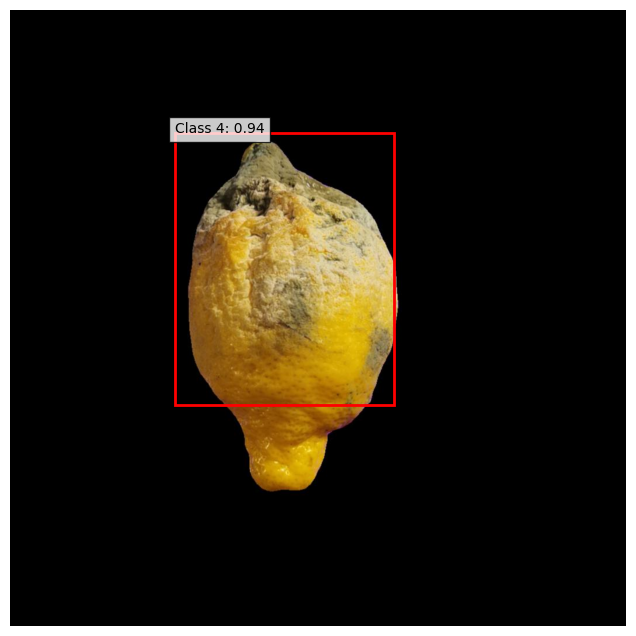


Testing image: image_subset/test/images/0001_G_V_75_A.jpg


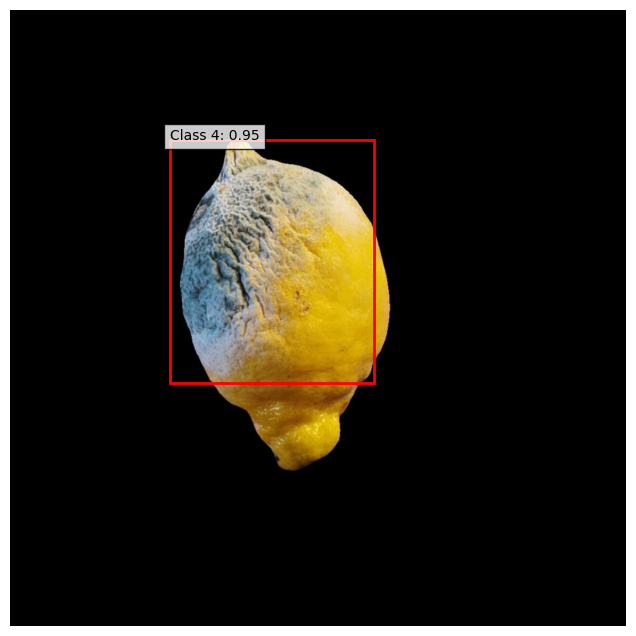


Testing image: image_subset/test/images/0012_G_H_15_F.jpg


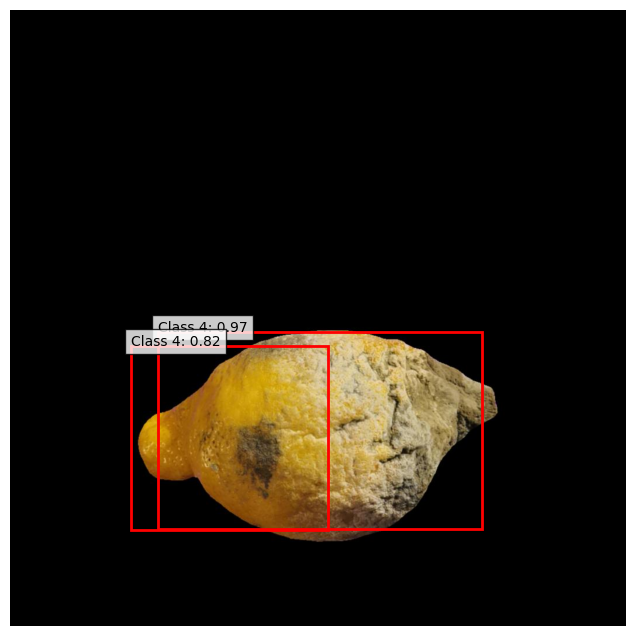


Testing image: image_subset/test/images/0022_G_I_135_F.jpg


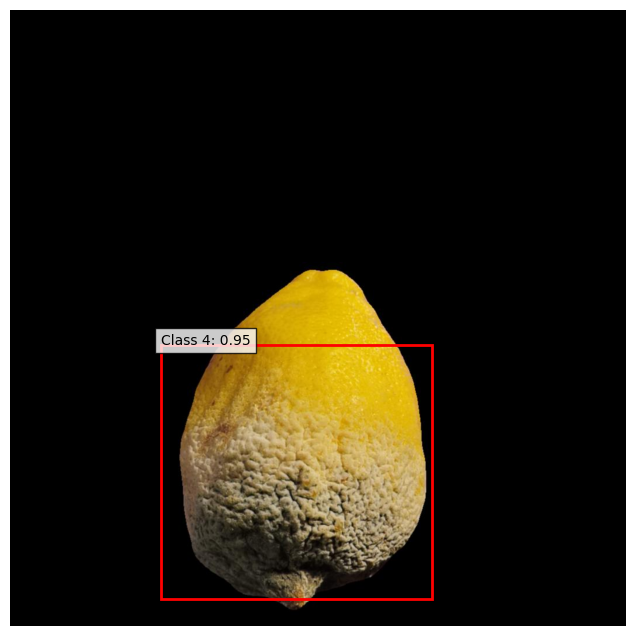


Testing image: image_subset/test/images/0012_G_H_90_F.jpg


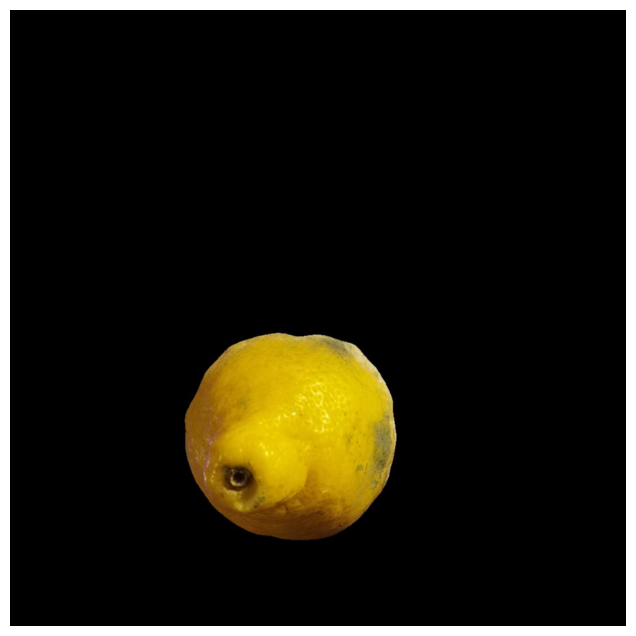


Testing image: image_subset/test/images/0001_G_I_15_A.jpg


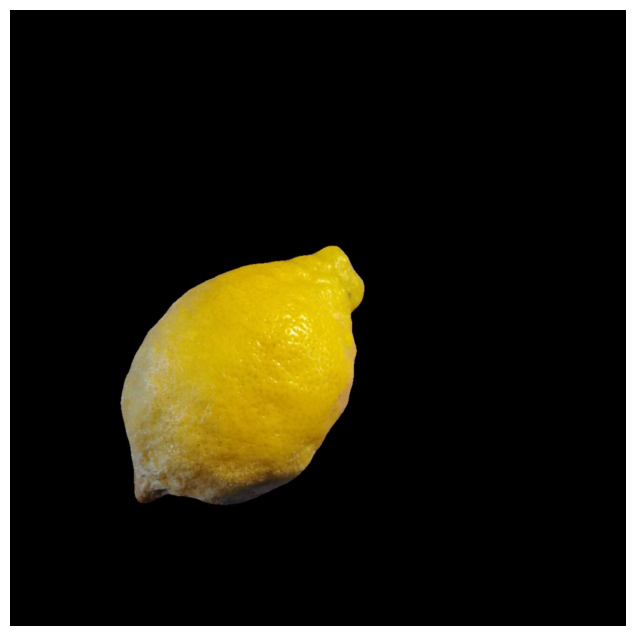


Testing image: image_subset/test/images/0002_C_V_105_G.jpg


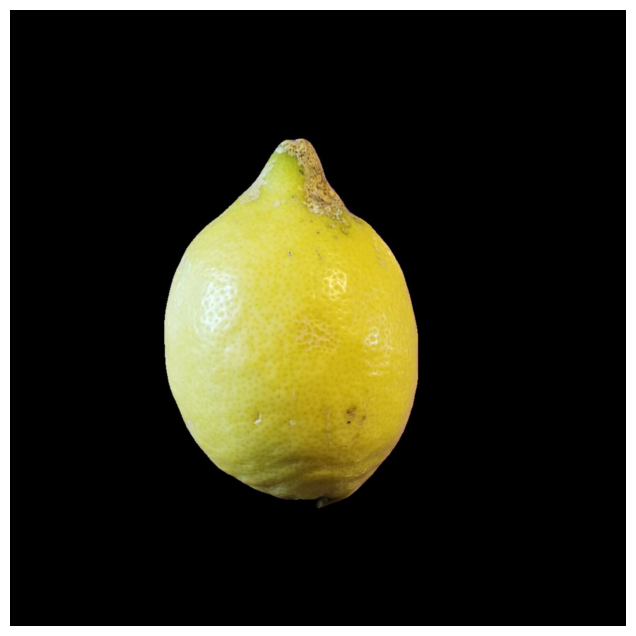

In [109]:
import torch
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import boto3
import io
import random  # Add this import
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

class LemonPredictor:
    def __init__(self, model_path, device='cuda' if torch.cuda.is_available() else 'cpu'):
        self.device = device
        self.num_classes = 10  # 9 defect classes + 1 background
        
        # Initialize model
        self.model = maskrcnn_resnet50_fpn(pretrained=False)
        in_features = self.model.roi_heads.box_predictor.cls_score.in_features
        self.model.roi_heads.box_predictor = FastRCNNPredictor(in_features, self.num_classes)
        in_features_mask = self.model.roi_heads.mask_predictor.conv5_mask.in_channels
        self.model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, 256, self.num_classes)
        
        # Load weights with weights_only=True to address the warning
        self.model.load_state_dict(torch.load(model_path, map_location=device, weights_only=True))
        self.model.to(device)
        self.model.eval()
        
        # Transform
        self.transform = T.Compose([T.ToTensor()])
        
    def predict_s3_image(self, bucket, key, confidence_threshold=0.7):
        try:
            # Download image from S3
            s3 = boto3.client('s3')
            response = s3.get_object(Bucket=bucket, Key=key)
            image_bytes = response['Body'].read()
            
            # Convert to PIL Image
            image = Image.open(io.BytesIO(image_bytes)).convert("RGB")
            return self.predict_image(image, confidence_threshold)
        except Exception as e:
            print(f"Error processing image {key}: {str(e)}")
            return None
    
    def predict_image(self, image, confidence_threshold=1.0):
        # Transform image
        image_tensor = self.transform(image).unsqueeze(0).to(self.device)
        
        # Get predictions
        with torch.no_grad():
            predictions = self.model(image_tensor)
        
        # Filter predictions based on confidence
        pred = predictions[0]
        mask = pred['scores'] > confidence_threshold
        
        return {
            'boxes': pred['boxes'][mask].cpu().numpy(),
            'labels': pred['labels'][mask].cpu().numpy(),
            'scores': pred['scores'][mask].cpu().numpy(),
            'masks': pred['masks'][mask].cpu().numpy() if 'masks' in pred else None
        }

# Initialize predictor
predictor = LemonPredictor('model_artifact/model.pth')

# Test on S3 images
def test_s3_images(bucket, prefix, num_images=5):
    s3 = boto3.client('s3')
    
    try:
        # List objects in the prefix
        response = s3.list_objects_v2(Bucket=bucket, Prefix=prefix)
        
        if 'Contents' not in response:
            print(f"No images found in bucket {bucket} with prefix {prefix}")
            return
            
        image_keys = [obj['Key'] for obj in response['Contents'] 
                     if obj['Key'].lower().endswith(('.png', '.jpg', '.jpeg'))]
        
        if not image_keys:
            print(f"No image files found in bucket {bucket} with prefix {prefix}")
            return
            
        # Select random images
        num_images_to_test = min(num_images, len(image_keys))
        test_keys = random.sample(image_keys, num_images_to_test)
        
        for key in test_keys:
            print(f"\nTesting image: {key}")
            results = predictor.predict_s3_image(bucket, key)
            
            if results is None:
                continue
                
            # Download and display image with predictions
            response = s3.get_object(Bucket=bucket, Key=key)
            image = Image.open(io.BytesIO(response['Body'].read())).convert("RGB")
            
            # Visualize results
            plt.figure(figsize=(12, 8))
            plt.imshow(np.array(image))
            
            for box, label, score in zip(results['boxes'], results['labels'], results['scores']):
                x1, y1, x2, y2 = box.astype(int)
                plt.gca().add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1, 
                                                fill=False, color='red', linewidth=2))
                plt.text(x1, y1, f'Class {label}: {score:.2f}', 
                        bbox=dict(facecolor='white', alpha=0.8))
            
            plt.axis('off')
            plt.show()
            
    except Exception as e:
        print(f"Error during testing: {str(e)}")

# Test images from your S3 bucket
test_s3_images(BUCKET_NAME, "image_subset/test/", num_images=20)

In [110]:
import os
import torch

# Use SM_MODEL_DIR if set; otherwise, default to a local "model" folder.
model_dir = os.environ.get("SM_MODEL_DIR", "./model")
os.makedirs(model_dir, exist_ok=True)  # Create the directory if it doesn't exist

model_path = os.path.join(model_dir, "model.pth")
torch.save(model.state_dict(), model_path)
print("Model saved to", model_path)


Model saved to ./model/model.pth


Couldn't extract label from filename: image_subset/train/images/0020_G_I_135_[F.jpg
Couldn't extract label from filename: image_subset/train/images/0020_G_H_30_[F.jpg
Couldn't extract label from filename: image_subset/train/images/0020_G_H_75_[F.jpg
Couldn't extract label from filename: image_subset/train/images/0020_G_I_120_[F.jpg
Couldn't extract label from filename: image_subset/train/images/0020_G_I_105_[F.jpg
Couldn't extract label from filename: image_subset/train/images/0020_G_I_60_[F.jpg
Couldn't extract label from filename: image_subset/train/images/0020_G_I_30_[F.jpg
Couldn't extract label from filename: image_subset/train/images/0020_G_H_135_[F.jpg
Couldn't extract label from filename: image_subset/train/images/0020_G_H_45_[F.jpg
Couldn't extract label from filename: image_subset/train/images/0020_G_H_90_[F.jpg
Successfully processed 73 images
Generating performance visualizations...


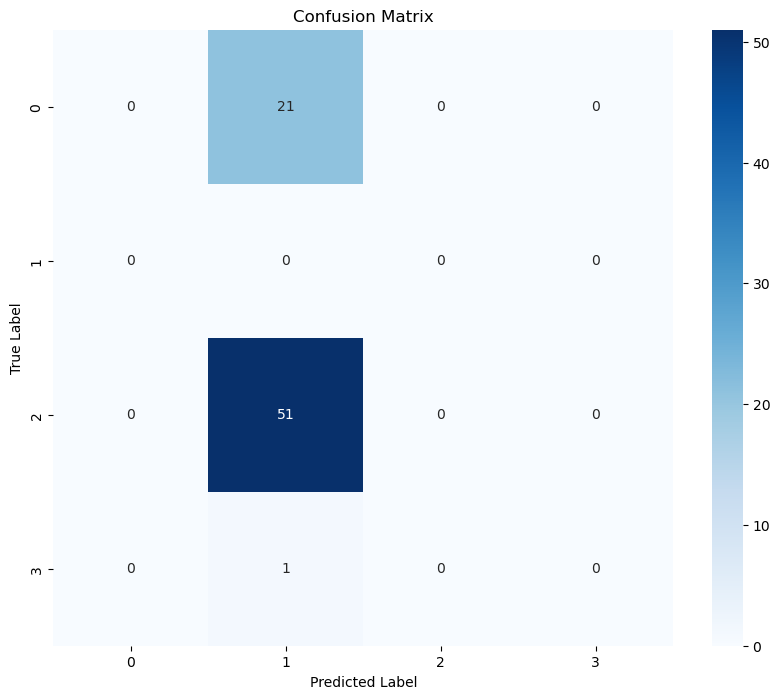

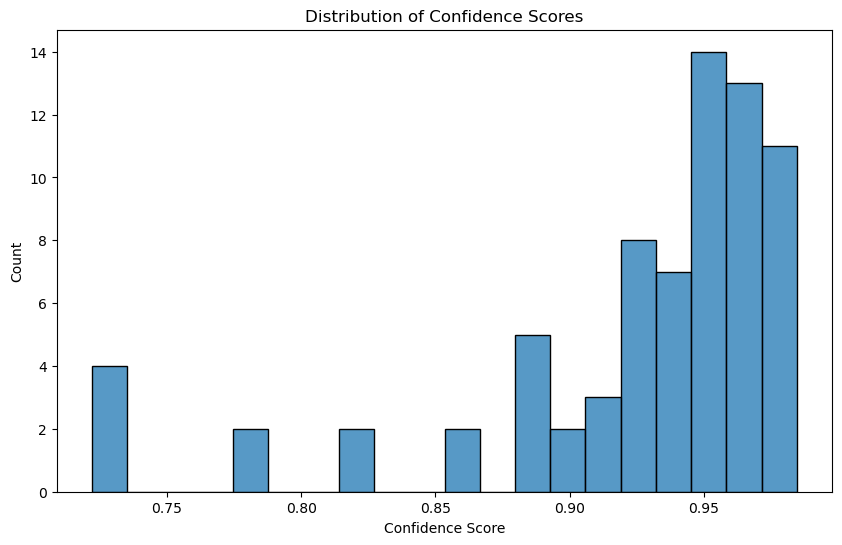

/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_

[04/08/25 21:17:25] INFO     Using categorical units to plot a list of strings that are all         ]8;id=62069;file:///opt/conda/lib/python3.11/site-packages/matplotlib/category.py\category.py]8;;\:]8;id=820864;file:///opt/conda/lib/python3.11/site-packages/matplotlib/category.py#224\224]8;;\
                             parsable as floats or dates. If these strings should be plotted as                    
                             numbers, cast to the appropriate data type before plotting.                           

                    INFO     Using categorical units to plot a list of strings that are all         ]8;id=380117;file:///opt/conda/lib/python3.11/site-packages/matplotlib/category.py\category.py]8;;\:]8;id=659471;file:///opt/conda/lib/python3.11/site-packages/matplotlib/category.py#224\224]8;;\
                             parsable as floats or dates. If these strings should be plotted as                    
                             numbers, cast to the appropriate data type before plotting.                           

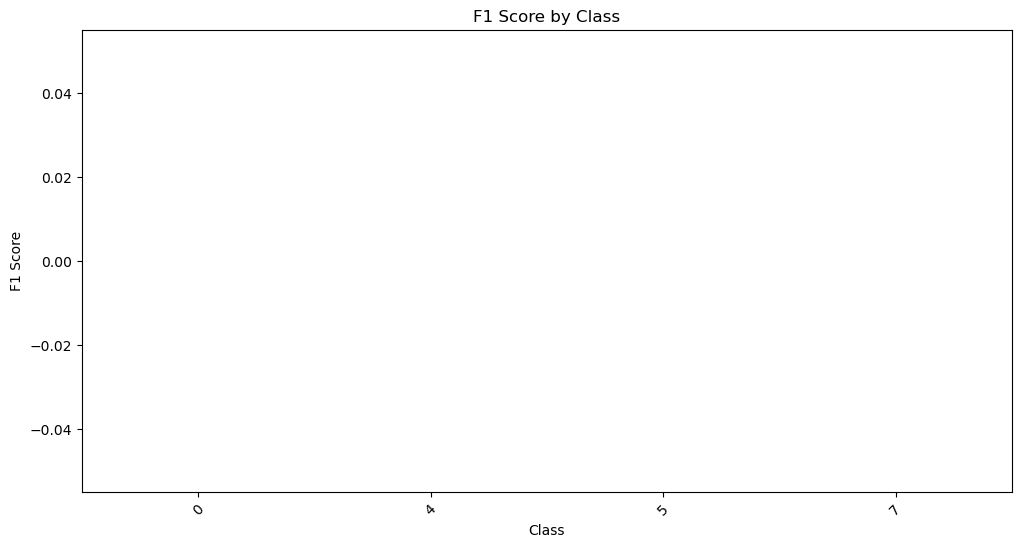

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      21.0
           4       0.00      0.00      0.00       0.0
           5       0.00      0.00      0.00      51.0
           7       0.00      0.00      0.00       1.0

    accuracy                           0.00      73.0
   macro avg       0.00      0.00      0.00      73.0
weighted avg       0.00      0.00      0.00      73.0



/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_

In [111]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import re

class ModelAnalyzer:
    def __init__(self, predictor):
        self.predictor = predictor
        self.true_labels = []
        self.pred_labels = []
        self.confidence_scores = []
        
    def get_label_from_filename(self, filename):
        # Extract the last character before .jpg (e.g., 'A' or 'F' from '0010_G_H_150_A.jpg')
        match = re.search(r'_([A-Z])\.jpg$', filename)
        if match:
            label = match.group(1)
            # Convert letter to number (A=0, F=1, G=2, etc.)
            return ord(label) - ord('A')
        return None
        
    def collect_predictions(self, bucket, prefix, num_images=None):
        s3 = boto3.client('s3')
        response = s3.list_objects_v2(Bucket=bucket, Prefix=prefix)
        
        if 'Contents' not in response:
            print("No images found in the specified bucket/prefix")
            return
            
        image_keys = [obj['Key'] for obj in response['Contents'] 
                     if obj['Key'].lower().endswith(('.png', '.jpg', '.jpeg'))]
        
        if num_images:
            image_keys = random.sample(image_keys, min(num_images, len(image_keys)))
            
        for key in image_keys:
            try:
                # Get label from filename
                true_label = self.get_label_from_filename(key)
                if true_label is None:
                    print(f"Couldn't extract label from filename: {key}")
                    continue
                
                results = self.predictor.predict_s3_image(bucket, key)
                if results is not None and len(results['labels']) > 0:
                    # Get the prediction with highest confidence
                    max_conf_idx = np.argmax(results['scores'])
                    pred_label = results['labels'][max_conf_idx]
                    confidence = results['scores'][max_conf_idx]
                    
                    self.true_labels.append(true_label)
                    self.pred_labels.append(pred_label)
                    self.confidence_scores.append(confidence)
                    
            except Exception as e:
                print(f"Error processing {key}: {str(e)}")
        
        print(f"Successfully processed {len(self.true_labels)} images")
        
    def plot_confusion_matrix(self):
        if not self.true_labels:
            print("No data available for confusion matrix")
            return
            
        plt.figure(figsize=(10, 8))
        cm = confusion_matrix(self.true_labels, self.pred_labels)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.show()
        
    def plot_confidence_distribution(self):
        if not self.confidence_scores:
            print("No data available for confidence distribution")
            return
            
        plt.figure(figsize=(10, 6))
        sns.histplot(data=self.confidence_scores, bins=20)
        plt.title('Distribution of Confidence Scores')
        plt.xlabel('Confidence Score')
        plt.ylabel('Count')
        plt.show()
        
    def plot_accuracy_by_class(self):
        if not self.true_labels:
            print("No data available for accuracy by class")
            return
            
        report = classification_report(self.true_labels, self.pred_labels, output_dict=True)
        df = pd.DataFrame(report).transpose()
        
        plt.figure(figsize=(12, 6))
        sns.barplot(x=df.index[:-3], y=df['f1-score'][:-3])
        plt.title('F1 Score by Class')
        plt.xlabel('Class')
        plt.ylabel('F1 Score')
        plt.xticks(rotation=45)
        plt.show()
        
    def print_metrics(self):
        if not self.true_labels:
            print("No data available for metrics")
            return
            
        report = classification_report(self.true_labels, self.pred_labels)
        print("Classification Report:")
        print(report)

# Create analyzer and collect predictions
analyzer = ModelAnalyzer(predictor)
analyzer.collect_predictions(BUCKET_NAME, "image_subset/train/", num_images=100)

# Generate visualizations
print("Generating performance visualizations...")
analyzer.plot_confusion_matrix()
analyzer.plot_confidence_distribution()
analyzer.plot_accuracy_by_class()
analyzer.print_metrics()